##### Copyright 2023 Google LLC. SPDX-License-Identifier: Apache-2.0

Copyright 2023 Google LLC. SPDX-License-Identifier: Apache-2.0

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## **LLMs as General Pattern Machines:** ARC Benchmark

We observe that pretrained large language models (LLMs) are capable of autoregressively completing complex token sequences -- from arbitrary ones procedurally generated by probabilistic context-free grammars (PCFG), to more rich spatial patterns found in the Abstract Reasoning Corpus (ARC), a general AI benchmark, prompted in the style of ASCII art. Surprisingly, pattern completion proficiency can be partially retained even when the sequences are expressed using tokens randomly sampled from the vocabulary. These results suggest that without any additional training, LLMs can serve as general sequence modelers, driven by in-context learning. In this work, we investigate how these zero-shot capabilities may be applied to problems in robotics -- from extrapolating sequences of numbers that represent states over time to complete simple motions, to least-to-most prompting of reward-conditioned trajectories that can discover and represent closed-loop policies (e.g., a stabilizing controller for CartPole). While difficult to deploy today for real systems due to latency, context size limitations, and compute costs, the approach of using LLMs to drive low-level control may provide an exciting glimpse into how the patterns among words could be transferred to actions.

This colab runs GPT-3 on the ARC benchmark with consistent tokenization (described more in Sec. 4 of the main paper).

### **Quick Start:**

**Step 1.** Register for an [OpenAI API key](https://openai.com/blog/openai-api/) to use GPT-3 (there's a free trial) and enter it below

**Step 2.** Menu > Runtime > Run all

In [ ]:
openai_api_key = "your-api-key-here"

## **Setup**

This does a few things:
* Installs Python packages and sets OpenAI API key.
* Downloads the Abstract Reasoning Corpus (ARC) benchmark.

**Note:** only needs a CPU (public) runtime.

In [ ]:
!pip install openai transformers

import json
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import openai
import pickle
from transformers import GPT2Tokenizer
# import tiktoken  # Faster than GPT2Tokenizer.

openai.api_key = openai_api_key

if not os.path.exists("ARC"):
  !git clone https://github.com/fchollet/ARC

## **API:** Large Language Models

Define helper functions to call large language models and the tokenizer.

**Note:** this can get expensive.

In [ ]:
model = "text-davinci-003"
token_limit = 4096

def LLM(prompt, stop=None, max_tokens=256, temperature=0):
  responses = openai.Completion.create(engine=model, prompt=prompt, max_tokens=max_tokens, temperature=temperature, stop=stop)
  text = [response['text'] for response in responses['choices']]
  return text

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

LLM("hello world!")

["\n\nHello World! It's great to be here."]

## **Alphabet:** Token Set

Build a fixed token set by random sampling from the LLM's token vocabulary.

In [ ]:
item_delim = tokenizer.encode(",")
row_delim = tokenizer.encode("\n")
sample_delim = tokenizer.encode("---\n")

# Handpicked: comma-separated number matrices.
alphabet = [tokenizer.encode(" " + str(a))[0] for a in range(10)]
value_to_token = lambda x: {i:a for i, a in enumerate(alphabet)}[x]
print("Token Set:", {i:value_to_token(i) for i in np.arange(10)})

# Random sampled tokens.
# for seed_offset in range(20):
# seed_offset = 0
# np.random.seed(42 + seed_offset)
# alphabet = [int(i) for i in np.random.randint(tokenizer.vocab_size, size=10)]
# value_to_token = lambda x: {i:a for i, a in enumerate(alphabet)}[x]

Token Set: {0: 657, 1: 352, 2: 362, 3: 513, 4: 604, 5: 642, 6: 718, 7: 767, 8: 807, 9: 860}


## **Load:** ARC Benchmark

Load tasks from the ARC benchmark.

In [ ]:
def state_to_tokens(state, value_to_token_fn):
  tokens = []
  for row in state:
    for i, value in enumerate(row):
      tokens +=[value_to_token_fn(value)]
      if i < len(row) - 1:
        tokens += item_delim
    tokens += row_delim
  return tokens


def task_json_to_tokens(task_json, value_to_token_fn):

  # Training examples.
  train_samples = []
  for sample in task_json["train"]:
    tokens = []
    tokens += tokenizer.encode("input:\n")
    tokens += state_to_tokens(sample["input"], value_to_token_fn)
    tokens += tokenizer.encode("output:\n")
    tokens += state_to_tokens(sample["output"], value_to_token_fn)
    tokens += sample_delim
    train_samples.append(tokens)

  # Testing examples.
  test_inputs = []
  test_outputs = []
  for sample in task_json["test"]:
    inputs, outputs = [], []
    inputs += tokenizer.encode("input:\n")
    inputs += state_to_tokens(sample["input"], value_to_token_fn)
    inputs += tokenizer.encode("output:\n")
    test_inputs.append(inputs)
    outputs += state_to_tokens(sample["output"], value_to_token_fn)
    test_outputs.append(outputs)
  return train_samples, test_inputs, test_outputs

In [ ]:
tasks_jsons = []
tasks_names = []
tasks_len = []
task_dir = "ARC/data/training"
for task_file in sorted(os.listdir(task_dir)):
  with open(os.path.join(task_dir, task_file)) as fid:
    task_json = json.load(fid)
  tasks_jsons.append(task_json)
  tasks_names.append(task_file)
  tokens, _, _ = task_json_to_tokens(task_json, value_to_token)
  tasks_len.append(np.sum([len(sample) for sample in tokens]))

task_dir = "ARC/data/evaluation"
for task_file in sorted(os.listdir(task_dir)):
  with open(os.path.join(task_dir, task_file)) as fid:
    task_json = json.load(fid)
  tasks_jsons.append(task_json)
  tasks_names.append(task_file)
  tokens, _, _ = task_json_to_tokens(task_json, value_to_token)
  tasks_len.append(np.sum([len(sample) for sample in tokens]))

sorted_task_ids = np.argsort(tasks_len)

print("Total number of tasks:", len(sorted_task_ids))

Total number of tasks: 800


## **Example:** ARC Problem

Show the LLM prompt for an ARC problem and visualize the grids used as inputs and outputs.

In [ ]:
colors = [(0, 0, 0),
          (0, 116, 217),
          (255, 65, 54),
          (46, 204, 6),
          (255, 220, 0),
          (170, 170, 170),
          (240, 18, 190),
          (255, 133, 27),
          (127, 219, 255),
          (135, 12, 37)]

def grid_to_img(grid):
  grid = np.int32(grid)
  scale = 10
  img = np.zeros((grid.shape[0] * scale + 1, grid.shape[1] * scale + 1, 3), dtype=np.uint8)
  for r in range(grid.shape[0]):
    for c in range(grid.shape[1]):
      img[r*scale+1:(r+1)*scale, c*scale+1:(c+1)*scale, :] = colors[grid[r, c]]
  new_img = img.copy()
  new_img[0::10, :, :] = np.uint8(np.round((0.7 * np.float32(img[0::10, :, :]) + 0.3 * 255)))
  new_img[:, 0::10, :] = np.uint8(np.round((0.7 * np.float32(img[:, 0::10, :]) + 0.3 * 255)))
  return new_img

PROMPT:
input:
 3, 3, 8
 3, 7, 0
 5, 0, 0
output:
 0, 0, 5
 0, 7, 3
 8, 3, 3
---
input:
 5, 5, 2
 1, 0, 0
 0, 0, 0
output:
 0, 0, 0
 0, 0, 1
 2, 5, 5
---
input:
 6, 3, 5
 6, 8, 0
 4, 0, 0
output:

SOLUTION:
 0, 0, 4
 0, 8, 6
 5, 3, 6

TRAIN:


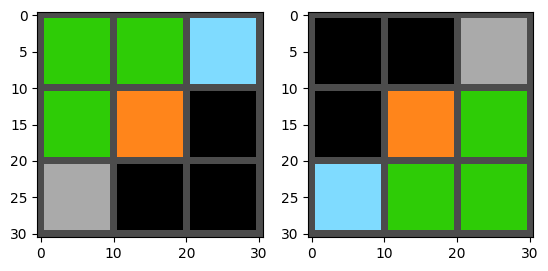

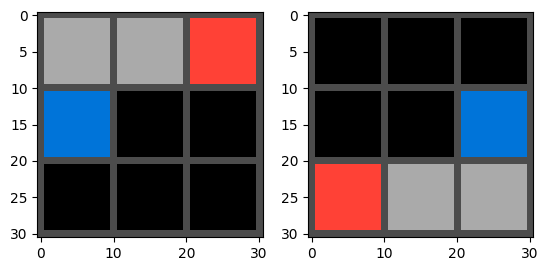

TEST:


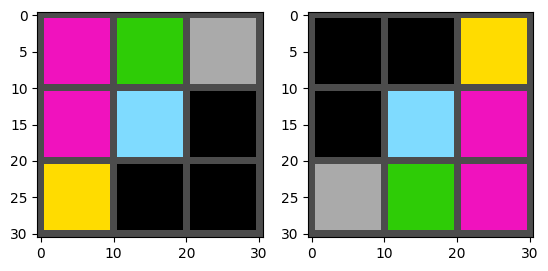

In [ ]:
example_json = tasks_jsons[sorted_task_ids[0]]

context = []
train_xy, test_x, test_y = task_json_to_tokens(example_json, value_to_token)
for sample in train_xy:
  context += sample
context += test_x[0]

print("PROMPT:")
print(tokenizer.decode(context, skip_special_tokens=True))
print("SOLUTION:")
print(tokenizer.decode(test_y[0], skip_special_tokens=True))

# Show problem.
print("TRAIN:")
for i, ex in enumerate(example_json["train"]):
  in_img = grid_to_img(ex["input"])
  out_img = grid_to_img(ex["output"])
  plt.subplot(1, 2, 1); plt.imshow(grid_to_img(ex["input"]))
  plt.subplot(1, 2, 2); plt.imshow(grid_to_img(ex["output"]))
  plt.show()
print("TEST:")
for i, ex in enumerate(example_json["test"]):
  in_img = grid_to_img(ex["input"])
  out_img = grid_to_img(ex["output"])
  plt.subplot(1, 2, 1); plt.imshow(grid_to_img(ex["input"]))
  plt.subplot(1, 2, 2); plt.imshow(grid_to_img(ex["output"]))
  plt.show()

## **Evaluate:** ARC Benchmark

Evaluate on the available 800 tasks.

**Note:** LLM temperature is set to 0 (deterministic), but your results might still vary depending on stability of the API.

In [ ]:
success = {}
for task_id in sorted_task_ids:
  task_json, task_name = tasks_jsons[task_id], tasks_names[task_id]

  # Lazy load: skip evals where we already have results.
  if task_name in success:
    continue

  # Build context and expected output labels.
  context = []
  batch_prompts = []
  batch_labels = []
  train_xy, test_x, test_y = task_json_to_tokens(task_json, value_to_token)
  test_num_tokens = np.max([len(x) + len(y) for x, y in zip(test_x, test_y)])
  for sample in train_xy:
    if len(context) + len(sample) + test_num_tokens > token_limit:  # Ensure both train and test examples can fit in the prompt.
      break
    context += sample

  # There can be multiple test examples so put them in the same batch.
  for x, y in zip(test_x, test_y):
    batch_prompts.append(context + x)
    batch_labels.append(y)

  # Run LLM.
  try:
    stop_token = tokenizer.decode(sample_delim, skip_special_tokens=True)
    max_tokens = int(np.max([len(y) for y in test_y])) + 10
    batch_responses = LLM(batch_prompts, stop=stop_token, max_tokens=max_tokens, temperature=0)
  except Exception as e:
    print(task_name, f"LLM failed. {e}")
    continue

  # Check answers and save success rates.
  success[task_name] = 0
  for response, label in zip(batch_responses, batch_labels):
    label_str = tokenizer.decode(label, skip_special_tokens=True)
    is_success = label_str.strip() in response
    success[task_name] += is_success / len(batch_labels)
  success[task_name] = int(success[task_name] > 0.99)  # All test cases need to correct.

  # Debug prints.
  total_success = np.sum(list(success.values()))
  print(task_name, "Success:", success[task_name], "Total:", f"{total_success} / {len(success)}")

  # # Save results.
  # result_file = f"arc-{model}-alphabet-{'-'.join(map(str, alphabet))}.pkl"
  # with open(result_file, 'wb') as fid:
  #   pickle.dump(success, fid, protocol=pickle.HIGHEST_PROTOCOL)